# Part 1: Cluster wallets based on how they interact with contracts

In [1]:
# 📊 Data Handling
import pandas as pd
import numpy as np

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# ⚙️ Preprocessing & Scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 📈 Analysis
import scipy.stats as stats
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
  
# 🧠 Modeling
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('Transactions.csv')

# 1.1 Feature Engineering

In [42]:
df = data.copy()
df['BLOCK_TIMESTAMP'] = pd.to_datetime(df['BLOCK_TIMESTAMP'])
df = df.sort_values(by=['FROM_ADDRESS', 'BLOCK_TIMESTAMP'])
df.head()

,FROM_ADDRESS,TO_ADDRESS,VALUE,GAS,GAS_USED,BLOCK_TIMESTAMP,TX_HASH,FUNCTION_NAME,TYPE
66210,0x0000000000000068f116a894984e2db1123eb395,0x000056f7000000ece9003ca63978907a00ffd100,0.0,496693.0,10104.0,2024-09-25 00:17:11,0xce6ce49a75ff1df05cefb70ed12e6c8e645a07395c31...,authorizeOrder,CALL
41083,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,94123.0,80185.0,2024-09-25 03:35:47,0xb4251303dd607d82c309529affe7b78cb132a04bad8d...,execute,CALL
2518,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,132670.0,55713.0,2024-09-25 03:50:35,0xd265d449efb2b05801935d76a0ee5ab80127af50f941...,execute,CALL
11427,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,101573.0,42176.0,2024-09-25 04:00:11,0xcf81214c433d453ce315039534d1d760ffb450bca06c...,execute,CALL
97931,0x0000000000000068f116a894984e2db1123eb395,0x1e0049783f008a0085193e00003d00cd54003c71,0.0,138015.0,49248.0,2024-09-25 04:07:11,0xfec1b2e6a7936bc0c14d06542ce1873d8491eca33ca7...,execute,CALL


In [43]:
#unique_function_count: Number of unique functions used
unique_function_count = df.groupby(['FROM_ADDRESS'])['FUNCTION_NAME'].nunique().rename('unique_function_count')

# total_tx_count: Total number of transactions
total_tx_count = df.groupby(['FROM_ADDRESS'])['TX_HASH'].nunique().rename('total_tx_count')

# avg_value_sent: Mean of VALUE
avg_value_sent = df.groupby(['FROM_ADDRESS'])['VALUE'].mean().rename('avg_value_sent')

# total_value_sent: Sum of VALUE
total_value_sent = df.groupby(['FROM_ADDRESS'])['VALUE'].sum().rename('total_value_sent')

# avg_gas_used: Mean of GAS_USED
avg_gas_used = df.groupby(['FROM_ADDRESS'])['GAS_USED'].mean().rename('avg_gas_used')

# gas_efficiency: GAS_USED / GAS averaged (how efficient they are)
avg_gas_used = df.groupby(['FROM_ADDRESS'])['GAS_USED'].mean()
avg_gas_provided = df.groupby(['FROM_ADDRESS'])['GAS'].mean()
gas_efficiency = (avg_gas_used / avg_gas_provided).rename('gas_efficiency')


# active_days: Number of days they were active 
active_days = df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].nunique().rename('active_days')

# contract_diversity: Number of unique TO_ADDRESS used
contract_diversity = df.groupby(['FROM_ADDRESS'])['TO_ADDRESS'].nunique().rename('contract_diversity')

# avg_tx_per_day: total_tx_count / active_days
avg_tx_per_day = ((df.groupby(['FROM_ADDRESS'])['TX_HASH'].nunique()) / (df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].nunique())).rename('avg_tx_per_day')

# first_last_tx_diff: Activity duration in days
first_last_tx_diff = ((df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].max()) - (df.groupby(['FROM_ADDRESS'])['BLOCK_TIMESTAMP'].min())).rename('first_last_tx_diff')


# final data frame
df_features = pd.concat([
    unique_function_count,
    total_tx_count,
    avg_value_sent,
    total_value_sent,
    avg_gas_used,
    gas_efficiency,
    active_days,
    contract_diversity,
    avg_tx_per_day,
    first_last_tx_diff
], axis=1).reset_index()

In [44]:
float_cols = ['avg_value_sent', 'gas_efficiency', 'avg_tx_per_day']
df_features[float_cols] = df_features[float_cols].round(2)
df_features['first_last_tx_diff'] = df_features['first_last_tx_diff'].dt.days


In [45]:
df_features

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,2,0.00,0.000000,73820.000000,0.96,2,1,1.00,0.0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,1,0.00,0.000000,51664.000000,0.76,1,1,1.00,0.0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,1,0.00,0.000000,3474.000000,0.00,1,1,1.00,0.0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,1,0.00,0.000000,100479.000000,0.96,1,1,1.00,0.0


# 1.2 EDA

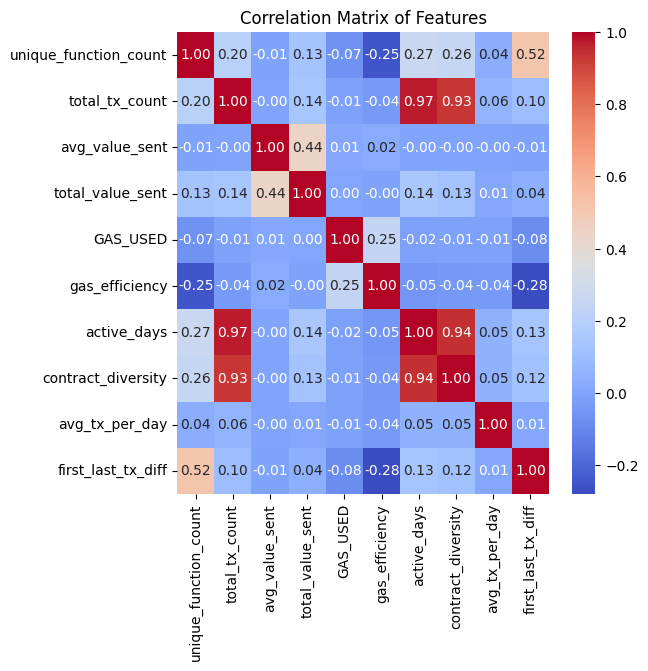

In [46]:
# Correlation Matrix 
plt.figure(figsize=(6, 6))
sns.heatmap(df_features.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

## Based on the correlation matrix, we better to:
### keep contract_diversity and remove total_tx_count and active_days
### keep first_last_tx_diff and unique_function_count >> duration activity+complexity
### so-so avg_tx_per_day
### so-so gas_efficiency
### so-so avg_value_sent >> indenify whales
### remove total_value_sent
### remove GAS_USED

In [47]:
df_features.head()

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,62,0.00,0.000000,27522.709677,0.12,60,5,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,30,0.03,0.987639,102411.000000,0.46,29,4,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,1,0.00,0.000000,17807.000000,0.15,1,1,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,3,0.00,0.000000,8218.000000,0.01,3,3,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,2,0.00,0.000000,9028.000000,0.07,2,1,1.00,0.0


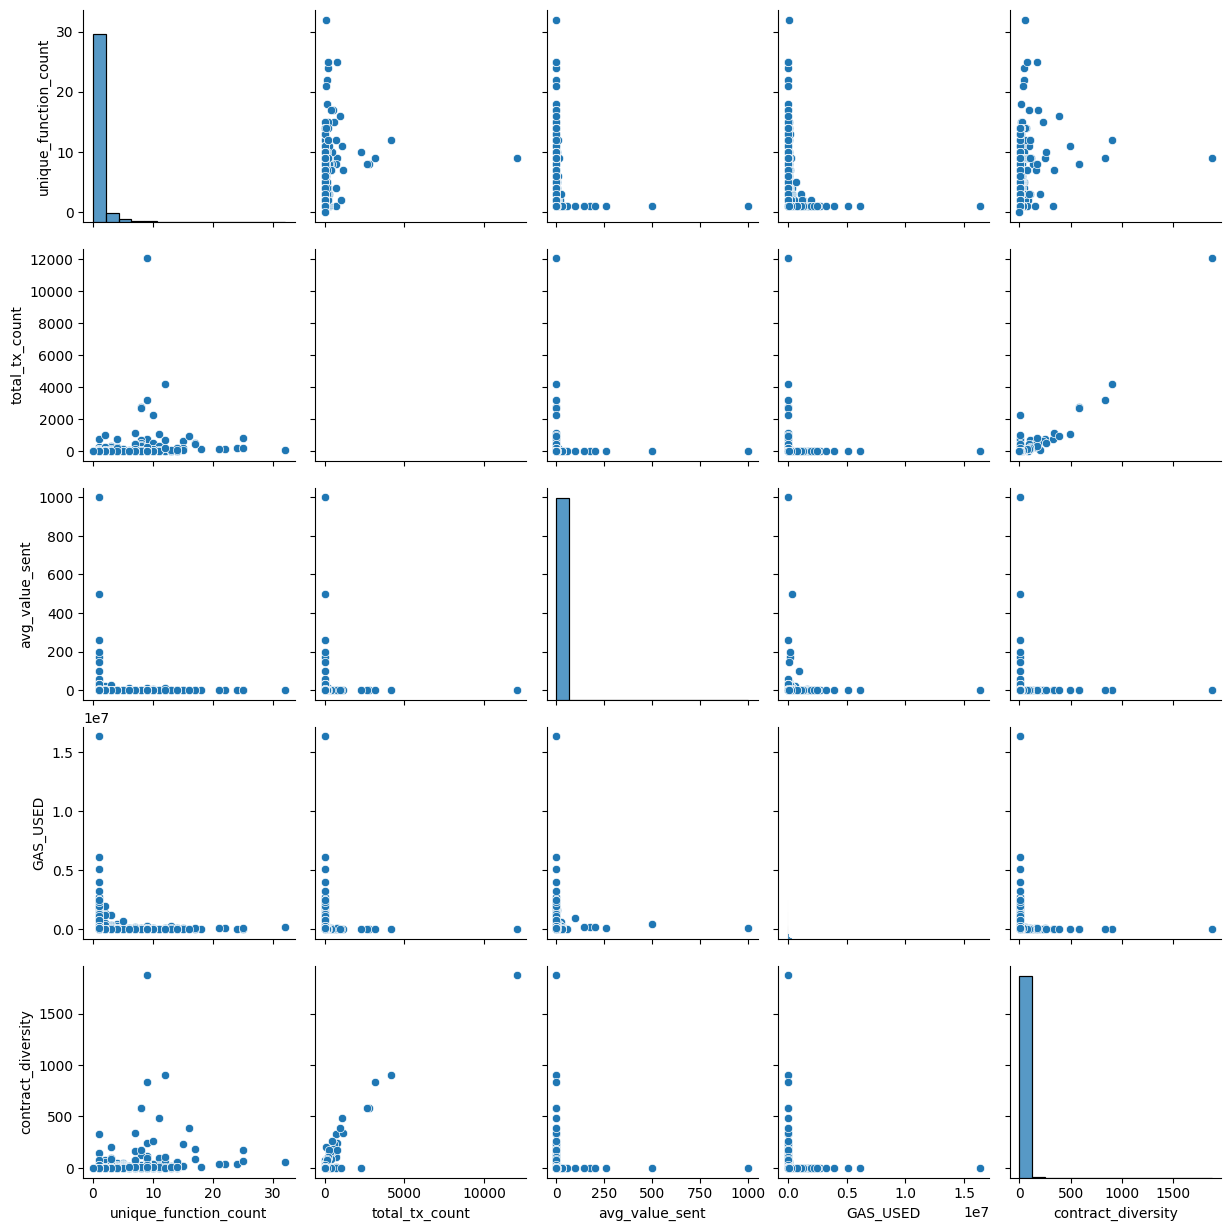

In [48]:
#Pairplot (Scatter Matrix) 
sns.pairplot(df_features[[
    'unique_function_count', 'total_tx_count', 'avg_value_sent',
    'GAS_USED', 'contract_diversity'
]])

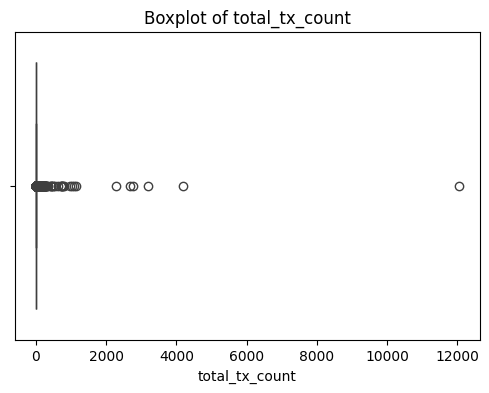

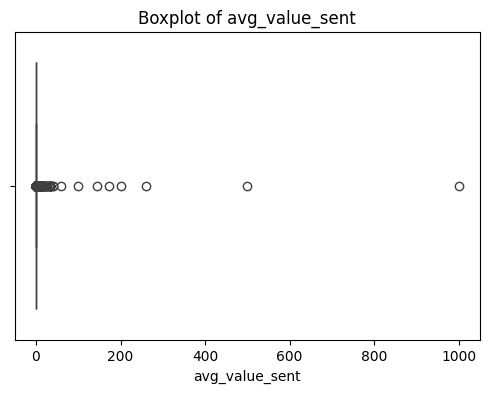

In [49]:
# Boxplots (Detect Outliers per Feature)
for feature in features_to_plot:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_features[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

In [50]:
df_features = df_features.fillna(0)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15520 entries, 0 to 15519
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FROM_ADDRESS           15520 non-null  object 
 1   unique_function_count  15520 non-null  int64  
 2   total_tx_count         15520 non-null  int64  
 3   avg_value_sent         15520 non-null  float64
 4   total_value_sent       15520 non-null  float64
 5   GAS_USED               15520 non-null  float64
 6   gas_efficiency         15520 non-null  float64
 7   active_days            15520 non-null  int64  
 8   contract_diversity     15520 non-null  int64  
 9   avg_tx_per_day         15520 non-null  float64
 10  first_last_tx_diff     15520 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 1.3+ MB


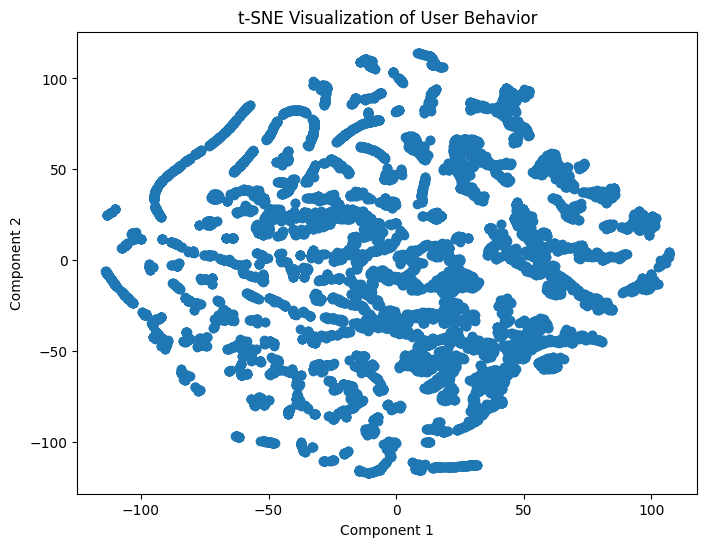

In [51]:
      
X = df_features.drop(columns=['FROM_ADDRESS']) 
X_scaled = StandardScaler().fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title("t-SNE Visualization of User Behavior")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [52]:
# Log Transformation for Skewed Features
df_transformed = df_features.copy()

cols_to_log = ['total_tx_count', 'avg_value_sent', 'GAS_USED', 'contract_diversity']

for col in cols_to_log:
    df_transformed[col] = np.log1p(df_transformed[col]) 

In [53]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0


In [54]:
# Feature Scaling
X = df_transformed.drop(columns=['FROM_ADDRESS'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
X_scaled

array([[ 2.11972409,  4.44037493, -0.15794123, ...,  2.57703406,
         0.11798292,  2.59163937],
       [ 1.30766549,  3.43982684, -0.03895616, ...,  2.09571743,
         0.11798292, -0.39296567],
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       ...,
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       [-0.3164517 , -0.42727018, -0.15794123, ..., -0.32322838,
        -0.04334703, -0.39296567],
       [-1.1285103 , -1.40524313, -0.15794123, ..., -2.15309024,
        -5.42101181, -0.39296567]])

/Users/bahareh/opt/anaconda3/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


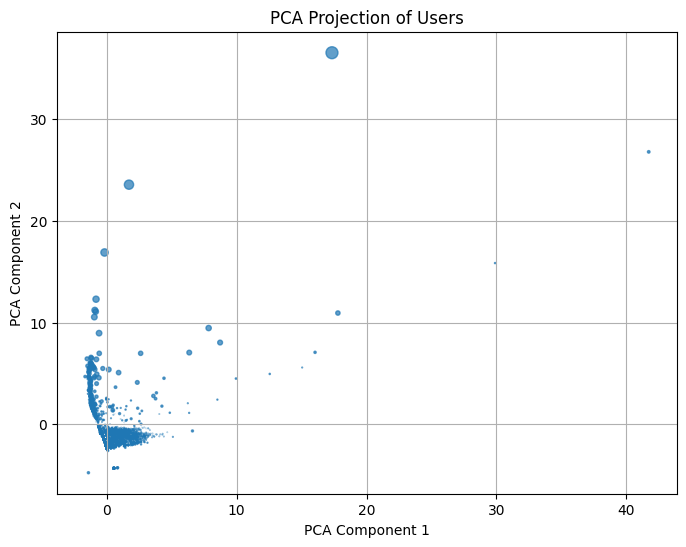

In [67]:
# Apply PCA 
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],  alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Users")
plt.grid(True)
plt.show()

In [72]:
from sklearn.cluster import DBSCAN

# Use PCA output for clustering (optional: use X_scaled directly for better accuracy)
dbscan = DBSCAN(eps=0.5, min_samples=5)
cluster_labels = dbscan.fit_predict(X_pca)

# Add cluster labels to your dataframe
df_transformed['cluster'] = cluster_labels

In [73]:
df_transformed

,FROM_ADDRESS,unique_function_count,total_tx_count,avg_value_sent,total_value_sent,GAS_USED,gas_efficiency,active_days,contract_diversity,avg_tx_per_day,first_last_tx_diff,cluster
0,0x0000000000000068f116a894984e2db1123eb395,4,4.143135,0.000000,0.000000,10.222803,0.12,60,1.791759,1.03,14.0,1
1,0x0000000000001ff3684f28c67538d4d072c22734,3,3.433987,0.029559,0.987639,11.536759,0.46,29,1.609438,1.03,0.0,-1
2,0x000000000000ad05ccc4f10045630fb830b95127,1,0.693147,0.000000,0.000000,9.787403,0.15,1,0.693147,1.00,0.0,0
3,0x000000000000c9b3e2c3ec88b1b4c0cd853f4321,3,1.386294,0.000000,0.000000,9.014204,0.01,3,1.386294,1.00,13.0,1
4,0x0000000000085d4780b73119b644ae5ecd22b376,2,1.098612,0.000000,0.000000,9.108197,0.07,2,0.693147,1.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15515,0xffee087852cb4898e6c3532e776e68bc68b1143b,1,1.098612,0.000000,0.000000,11.209399,0.96,2,0.693147,1.00,0.0,0
15516,0xfff1f7d097212ff54791121a06d5fa1e1aedfaf7,1,0.693147,0.000000,0.000000,10.852536,0.76,1,0.693147,1.00,0.0,0
15517,0xfff30c67eea809123596252e132d30e1eb75bc83,1,0.693147,0.000000,0.000000,8.153350,0.00,1,0.693147,1.00,0.0,0
15518,0xfff9691fce62fcebd90dfc2893e4f03b422514e8,1,0.693147,0.000000,0.000000,11.517714,0.96,1,0.693147,1.00,0.0,0


In [74]:
df_transformed['cluster'].value_counts()

 0     13183
 1      1756
-1       490
 3        11
 2        10
 6        10
 4         9
 5         8
 12        7
 9         7
 8         6
 13        5
 7         5
 10        5
 14        5
 11        3
Name: cluster, dtype: int64

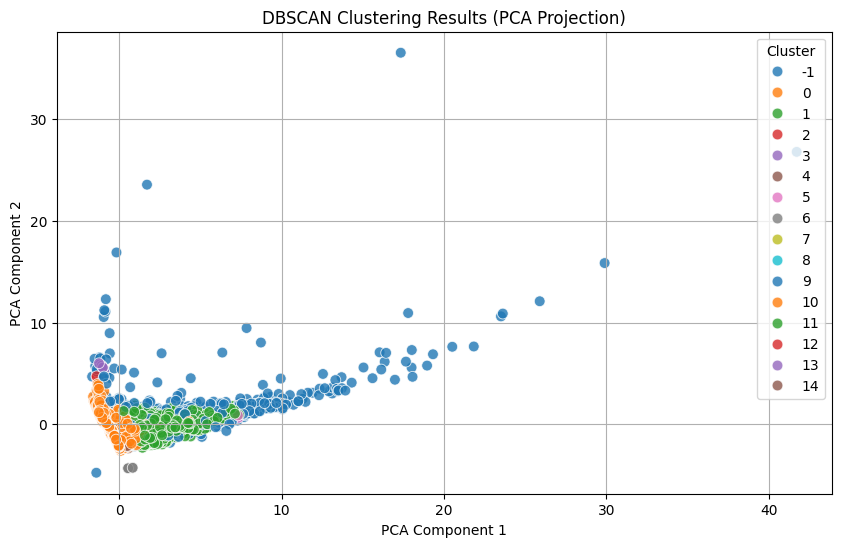

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1],
    hue=cluster_labels,
    palette="tab10",
    s=60,
    alpha=0.8,
    legend='full'
)
plt.title("DBSCAN Clustering Results (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Clustering

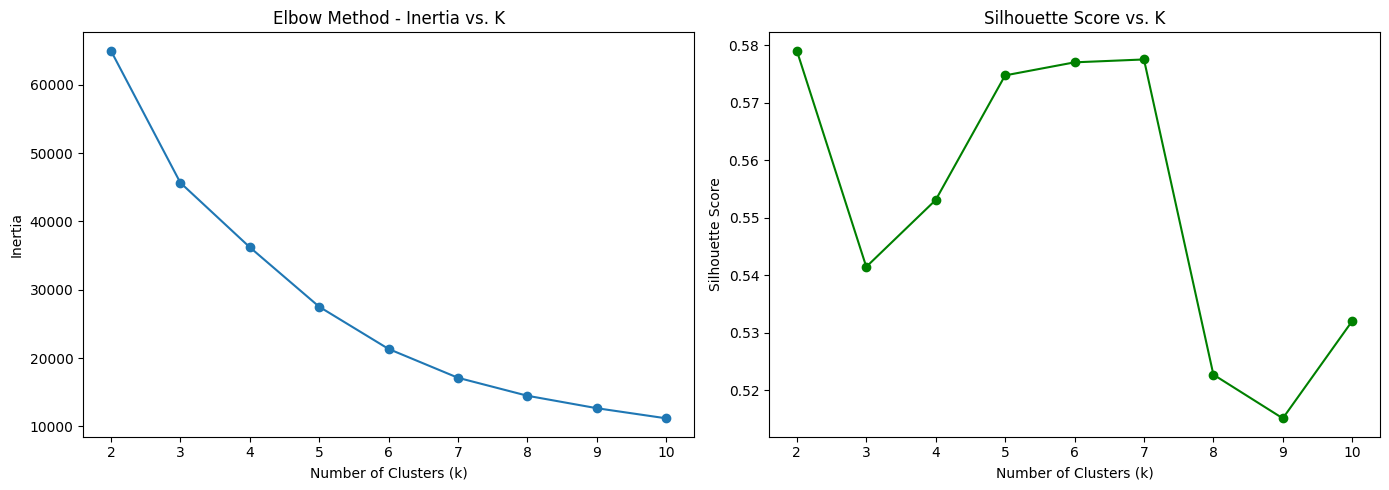

In [66]:
#  Elbow & Silhouette

inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) 
    labels = kmeans.fit_predict(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, labels))

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(k_range, inertia, marker='o')
ax[0].set_title('Elbow Method - Inertia vs. K')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')

ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
ax[1].set_title('Silhouette Score vs. K')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [69]:
X = df_transformed.drop(columns=['FROM_ADDRESS'], axis=1) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K=7
kmeans = KMeans(n_clusters=7, random_state=42, n_init='auto')
df_transformed['cluster'] = kmeans.fit_predict(X_scaled)

In [71]:
df_transformed['cluster'].value_counts()

1    8138
0    5160
6    1941
3     272
5       6
2       2
4       1
Name: cluster, dtype: int64

In [285]:

cluster_profile = final_data.groupby('cluster').mean()
cluster_profile


/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_9501/3241805672.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,tx_count_total,tx_count_week,tx_count_month,active_days_week,active_days_month,mean_time_between_txs_days,unique_contracts,category_diversity,top_contract_frequency,session_count
cluster,,,,,,,,,,
0,1.378294,1.336600,1.336600,1.0,1.0,0.094634,1.004097,1.000000,0.999356,1.126607
1,3198.000000,1686.750000,1686.750000,1.0,1.0,0.000000,724.500000,2.500000,0.403107,2.000000
2,7.573095,6.082361,6.082361,1.0,1.0,1.687714,2.513384,1.000000,0.556837,3.362388
3,2.000000,1.000000,1.000000,1.0,1.0,13.935233,1.471503,1.160622,0.764249,2.000000
4,52.902200,29.118582,29.118582,1.0,1.0,0.506112,13.014670,1.290954,0.554689,13.080685
5,12035.000000,6617.000000,6617.000000,1.0,1.0,0.000000,1872.000000,3.000000,0.376379,2.000000
6,22.298526,13.477887,13.477887,1.0,1.0,1.474201,6.654791,2.114251,0.571635,3.814496


/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_9501/1446872707.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nw/7766myvd65gfypd6nd1lgsb40000gn/T/ipykernel_9501/1446872707.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



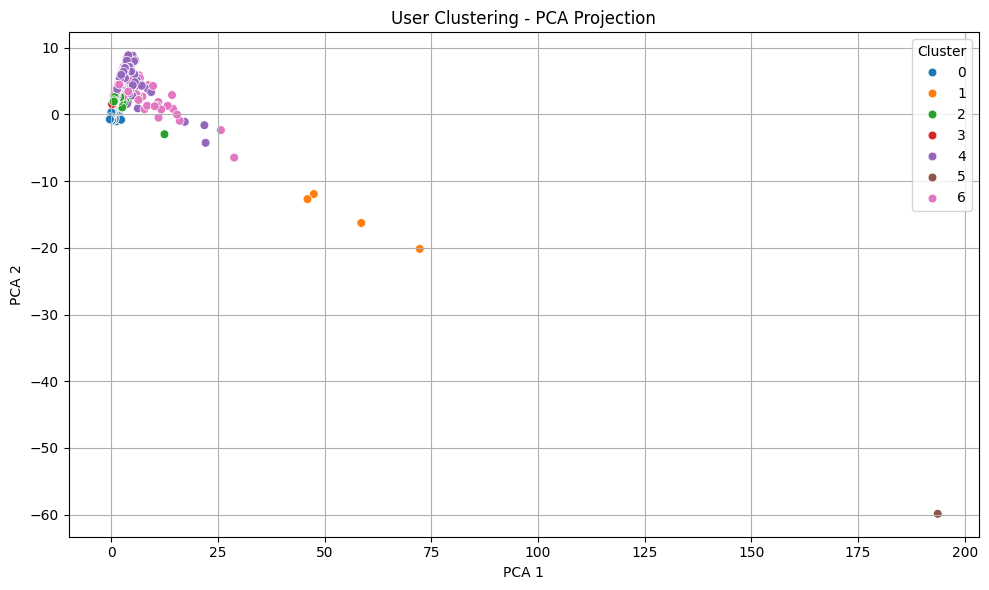

In [286]:

# اجرای PCA برای نمایش دو بعدی
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# اضافه کردن نتیجه PCA به دیتافریم
final_data['pca1'] = X_pca[:, 0]
final_data['pca2'] = X_pca[:, 1]

# رسم نمودار دو بعدی
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data, x='pca1', y='pca2', hue='cluster', palette='tab10', s=40)
plt.title('User Clustering - PCA Projection')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [217]:
# define category & sub category
function_mapping = {
    'swap': ('DeFi', 'DEX'),
    'swapExactETHForTokens': ('DeFi', 'DEX'),
    'swapExactETHForTokensSupportingFeeOnTransferTokens': ('DeFi', 'DEX'),
    'swapExactTokensForETHSupportingFeeOnTransferTokens': ('DeFi', 'DEX'),
    'uniswapV3SwapCallback': ('DeFi', 'DEX'),

    'transfer': ('DeFi', 'Token Transfer'),
    'transferFrom': ('DeFi', 'Token Transfer'),
    'approve': ('DeFi', 'Token Transfer'),
    'allowance': ('DeFi', 'Token Transfer'),
    'balanceOf': ('DeFi', 'Token Transfer'),

    'deposit': ('DeFi', 'Lending'),
    'withdraw': ('DeFi', 'Lending'),

    'getReserves': ('DeFi', 'Liquidity Pools'),
    'token0': ('DeFi', 'Liquidity Pools'),
    'token1': ('DeFi', 'Liquidity Pools'),
    'totalSupply': ('DeFi', 'Token Metadata'),
    'decimals': ('DeFi', 'Token Metadata'),

    'latestRoundData': ('Infrastructure', 'Oracle'),
    'latestAnswer': ('Infrastructure', 'Oracle'),

    'execute': ('Infrastructure', 'Smart Wallet'),
    'executeDelegateCall': ('Infrastructure', 'Smart Wallet'),
    'router': ('Infrastructure', 'Smart Wallet'),
    'WETH': ('Infrastructure', 'Smart Wallet'),
    'implementation': ('Infrastructure', 'Smart Wallet'),

    'resolve': ('Infrastructure', 'Proxy'),
    'getApp': ('Infrastructure', 'Proxy'),
    'getProvider': ('Infrastructure', 'Proxy'),

    'claimTokens': ('Rewards', 'Airdrop'),
    'mint': ('Rewards', 'Airdrop'),
    'permit': ('Rewards', 'Airdrop'),
    'claimMintRewardAndShare': ('Rewards', 'Airdrop'),
    'callClaimMintReward': ('Rewards', 'Airdrop'),

    'proposeBlock': ('Governance', 'Staking / L2 Infra'),
    'proveBlock': ('Governance', 'Staking / L2 Infra'),
    'powerDown': ('Governance', 'Staking / L2 Infra'),

    'transform': ('Utility', 'Other'),
    'fee': ('Utility', 'Other'),
    'max': ('Utility', 'Other'),
    'min': ('Utility', 'Other'),
}

default_category = ('Other', 'Uncategorized')

df[['category', 'sub_category']] = df['FUNCTION_NAME'].apply(
    lambda f: pd.Series(function_mapping.get(f, default_category))
)